In [ ]:
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import os
from pathlib import Path
from random import random
from shapely.geometry import Polygon
from shapely.ops import unary_union
import networkx as nx

DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'

In [ ]:
#Read_file_names
def read_file_names():
    os.chdir(''.join([DIR,'input']))
    fullPath = Path(''.join([DIR,'input']))
    paths = sorted(fullPath.iterdir(),key=os.path.getmtime)
    fileNames = [f.name for f in paths if  f.suffix == '.csv' ]
    print(fileNames)
    return fileNames

In [38]:
import pandas as pd
 
# read by default 1st sheet of an excel file
dataframes = pd.read_excel('C:/Users/wisch/Documents/GitProjects/CanopyHydrodynamics/data/validation_raw/StemFlowVolumes.xlsx',sheet_name = None)
 
print(dataframes.keys())

dict_keys(['Metadata', 'Hydrograph', 'Mapping', 'TraitExtraction', 'StemFlowVolume', 'DataByArea', 'Volume', 'Depth', 'Yield', 'VolumeByArea', 'YieldByArea', 'DepthByArea'])


In [66]:
#We want to graph correlations between the following extracted
#traits and the volume, depth and yield of flow:
# total_psa, stem_psa, stem_psa_w_overlap, total_surface_area, stem_surface_area
# total_hull_area, stem_hull_area, Total_WAI, stem_WAI, 
# DBH, some combination of stem angles

#But first... Data Prep

#Our model hypothesis is that, **assuming initial saturation**, (projected area - overlap) of the stem component will be 
# correlated to total stem flow volume. Perhaps there will also be a correlation between surface
# area and stem flow yield or rate 

#Cleaning
# Goals:
#   - Reduce the effect of the confounding variables:
#       - Data inaccuracy (for various reasons )
#       - Saturation level varying by tree
#       - 
# Methodology:
#   - Identify rain events that did not lead to saturation (varies by tree)
#   - Scrub data for rain events for which no data is available 
#   - Normalize the data based on saturation point
#       - *x-axis of mm since Saturation or time since saturation
#   - ?Perhaps adjust for tree pheological traits (species bark roughness?)

tree_name = 'A. platanoides'

#Read datasets (excel sheets) into dataframes
# volume = dataframes['Volume']
# depth = dataframes['Depth']
# tree_traits = dataframes['Mapping']

# Set indexes to easily access rows/join data sets
# tree_traits.set_index('Species', inplace=True)
# depth.set_index('Date', inplace=True)
# volume.set_index('Date', inplace=True)

# tree_metrics = dataframes['Mapping'].loc[[tree_name]]
# rain_sorted_vol   = volume.sort_values(by=['Rain'])
# rain_sorted_depth = depth.sort_values(by=['Rain'])
print(rain_sorted_depth)


         Date  Rain  Z. serrata  L. styraciflua  A. platanoides  \
7  2020-05-08   0.2        0.00            0.00            0.00   
15 2020-09-09   0.2        0.00            0.00            0.00   
20 2020-04-10   0.3        0.00            0.00            0.00   
9  2020-08-17   0.4        0.00            0.00            0.00   
19 2020-01-10   0.5        0.00            0.00            0.00   
4  2020-02-08   1.1        0.00            0.00            0.00   
18 2020-09-29   1.2        0.00            0.00            0.00   
1  2020-07-28   1.4        0.00            0.00            0.00   
31 2022-10-15   2.2        0.39            0.38            0.00   
2  2020-01-08   2.6        0.00            0.00            0.00   
13 2020-05-09   3.5        0.00            0.00            0.00   
16 2020-09-13   6.6        0.04            0.00            0.00   
32 2022-10-19   7.1        0.01            0.00            0.00   
10 2020-08-26   8.0        0.01            0.00            0.0

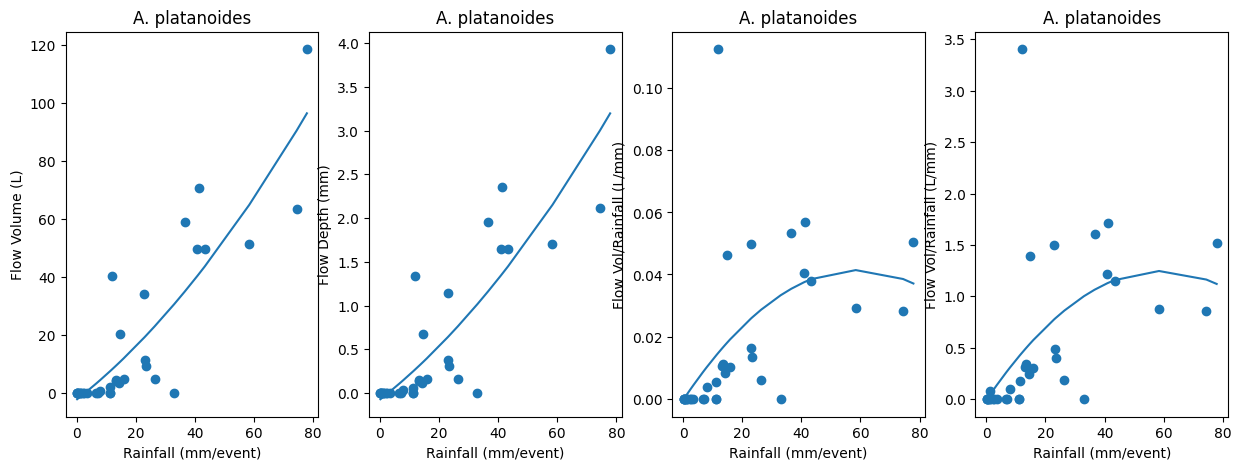

In [71]:
# Identification of saturation point 
# How to define:
#   - By volume of rain required before consistent stem flow is seen
#       - By comparison of stem flow vol/yield of each rain event together for each tree individually
#       - Similar to the above but with time on X, stem flow volume on Y for indv rain events 
#
# Viz wanted: 
#   - Volume/rain depth/stemflow yield by rain amount

# tree_list = set(dataframes['Mapping']['Species'])
# print(tree_list)

if 1==1:
# for tree in tree_list:

    tree_name = 'A. platanoides'
    tree_metrics = dataframes['Mapping'].loc[[tree_name]]
    import matplotlib.pyplot as plt
    import numpy as np

    # fig, ax = plt.subplots(n_rows = 1,n_cols = 4)
    fig, ax = plt.subplots(1,4, figsize=(15, 5))   
    
    title = f'Stemflow Volume (L) by Rainfall Event - {tree_name}'
    ax[0].set_title(tree_name)
    ax[0].set_xlabel('Rainfall (mm/event)')
    ax[0].set_ylabel('Flow Volume (L)')
    x = rain_sorted_vol['Rain']
    y = rain_sorted_vol[tree_name]
    ax[0].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    ax[0].plot(x, p(x) )


    title = f'Stemflow Depth by Rainfall Event - {tree_name}'
    ax[1].set_title(tree_name)
    ax[1].set_xlabel('Rainfall (mm/event)')
    ax[1].set_ylabel('Flow Depth (mm)')
    x = rain_sorted_depth['Rain']
    y = rain_sorted_depth[tree_name]
    ax[1].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    ax[1].plot(x, p(x) )

    title = f'Stemflow Volume Yield by Rainfall Event - {tree_name}'
    ax[2].set_title(tree_name)
    ax[2].set_xlabel('Rainfall (mm/event)')
    ax[2].set_ylabel('Flow Vol/Rainfall (L/mm)')
    x = rain_sorted_depth['Rain']
    y = rain_sorted_depth[tree_name]/rain_sorted_depth['Rain']
    ax[2].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    ax[2].plot(x, p(x) )

    title = f'Stemflow Volume Yield by Rainfall Event - {tree_name}'
    ax[3].set_title(tree_name)
    ax[3].set_xlabel('Rainfall (mm/event)')
    ax[3].set_ylabel('Flow Vol/Rainfall (L/mm)')
    x = rain_sorted_vol['Rain']
    y = rain_sorted_vol[tree_name]/rain_sorted_vol['Rain']
    ax[3].scatter(x, y )
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    ax[3].plot(x, p(x) )
    plt.show()